In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import numpy as np

import itertools
from time import sleep, time
import toolz
import numpy as np

In [3]:
import distributed
distributed.__file__

'/Users/ssievert/Developer/dask/distributed/distributed/__init__.py'

### Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def get_model(model=None):
    if model is None:
        return Net()
    return getattr(torchvision.models, model)()

resnet_models = [m for m in dir(torchvision.models)
                 if 'resnet' in m and m != 'resnet']
models = [get_model(model=model) for model in resnet_models]

In [5]:
from types import SimpleNamespace
args = SimpleNamespace(batch_size=64, test_batch_size=1000,
                       epochs=2, lr=0.01, momentum=0.5,
                       no_cuda=True, seed=42, log_interval=80)
    
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

### Dask

In [6]:
from dask.distributed import Client, wait
client = Client()
client

Client Scheduler: tcp://127.0.0.1:63705 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


### Parameter Server


In [7]:
import torch.optim as optim
import copy

def clone(model):
    return copy.deepcopy(model)

class PS:
    model = None
    n_steps = 0

    def __init__(self, model, args, device, num_workers=1, max_iter=30):
        model = model.to(device)
        self.model = model
        self._model = clone(model)
        self.optimizer = optim.SGD(self._model.parameters(), lr=args.lr, momentum=args.momentum)
        self.n_steps = 0
        self._grads_recvd = 0
        self._updating = False
        self.max_iter = max_iter
        self.num_workers = num_workers

    def pull(self):
        """
        For a worker to pull a model from this PS
        """
        return self.model

    def push(self, grads, key=None):
        """
        For a worker to push some gradients to this PS
        """
        if grads:
            if self.n_steps is not None and self.n_steps > self.max_iter:
                self.n_steps = None
            if self.n_steps is None:
                return None
            if key != self.n_steps or self._updating:
                assert key < self.n_steps
                return self.n_steps
            
            assert not self._updating
            if self._grads_recvd == 0:
                self.optimizer.zero_grad()
            
            self._grads_recvd += 1
            self.aggregate(grads)
            if self._grads_recvd == self.num_workers:
                self._updating = True
                self._grads_recvd = 0
                self.step()
                self.n_steps += 1
                self._updating = False
            return self.n_steps

    def aggregate(self, grads):
        for name, param in self._model.named_parameters():
            if param.grad is None:
                param.grad = 0 * param
            param.grad += grads[name]
            
    def step(self):
        self.optimizer.step()
        self.model = clone(self._model)

# Execution

In [8]:
def train(model, device, data, target):
    model.train()
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    return model

In [9]:
import toolz
def worker(ps, device, train_loader, worker_id=0):
    meta = {'comm_grad': 0, 'comm_model': 0, 'comp_grad': 0,
            'n_comm_grad': 0, 'n_steps': 0,
            'worker_id': worker_id}
    last_step = -1
    step = 0
    train_loader = iter(train_loader)
    start_step = ps.push(None).result()
    
    loop_start = time()
    while True:
        if step != last_step:
            start = time()
            model = ps.pull().result()
            last_step = step
            meta['comm_model'] += time() - start
            meta['n_steps'] += 1
            
        start = time()
        data, target = next(train_loader)
        model = train(model, device, data, target)
        meta['comp_grad'] += time() - start
        
        if True:
            check = toolz.first(model.parameters())
            check = check.detach().numpy().flat[:3]
            print(step, check)
        
        grads = {name: p.grad.data for name, p in model.named_parameters()}
        
        start = time()
        
        step = ps.push(grads, key=step).result()
        # ps.push(grads, key=step)#.result()
        # step = ps.n_steps
        
        meta['comm_grad'] += time() - start
        meta['n_comm_grad'] += 1
        
        if step is None:
            break
            
    meta['avg_comm_grad'] = meta['comm_grad'] / meta['n_comm_grad']
    meta['avg_comp_grad'] = meta['comp_grad'] / meta['n_comm_grad']
    meta['avg_comm_model'] = meta['comm_model'] / meta['n_steps']
    meta['opt_time'] = time() - loop_start
    return meta

In [10]:
def test(batch_size=128, num_workers=4, iters=30):
    batch_size //= num_workers
    model = Net()
    n_params = [np.prod(list(p.size())) for p in model.parameters()]
    
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)

    device = torch.device("cuda" if use_cuda else "cpu")
    train_loader, model = client.scatter([train_loader, model])

    ps = client.submit(PS, model, args, device,
                       max_iter=30, num_workers=num_workers,
                       actor=True, ).result()
    
    futures = [client.submit(worker, ps, device, train_loader, worker_id=i)
               for i in range(num_workers)]
    metas = client.gather(futures)
    metas = [{'worker_batch_size': batch_size,
              'num_workers': num_workers,
              'iters': iters,
              'params': sum(n_params),
              **m} for m in metas]
    return metas

In [11]:
data = [test(num_workers=num_workers)
        for num_workers in [1, 2, 4, 8]]
# test(num_workers=4)

In [12]:
import pandas as pd
df = pd.DataFrame(sum(data, []))
df.head()

,avg_comm_grad,avg_comm_model,avg_comp_grad,comm_grad,comm_model,comp_grad,iters,n_comm_grad,n_steps,num_workers,opt_time,params,worker_batch_size,worker_id
0,0.008530,0.008175,0.060826,0.272968,0.261599,1.946438,30,32,32,1,2.496775,21840,128,0
1,0.009909,0.010177,0.037920,0.505355,0.315493,1.933930,30,51,31,2,2.777652,21840,64,0
2,0.006200,0.010807,0.042570,0.248013,0.313411,1.702796,30,40,29,2,2.282890,21840,64,1
3,0.010154,0.012845,0.029170,0.578800,0.385362,1.662674,30,57,30,4,2.653737,21840,32,0
4,0.014177,0.017949,0.027238,0.864774,0.556427,1.661494,30,61,31,4,3.110744,21840,32,1


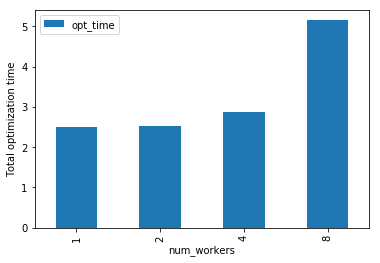

In [13]:
import matplotlib.pyplot as plt
show = df.pivot_table(index='num_workers', values='opt_time',
                      aggfunc=np.median)
show.plot.bar()
plt.ylabel('Total optimization time')
plt.savefig('total_opt_time.png', dpi=300)

In [14]:
r = df.groupby(['num_workers', 'worker_id'])['opt_time']
list(r)

[((1, 0), 0    2.496775
  Name: opt_time, dtype: float64), ((2, 0), 1    2.777652
  Name: opt_time, dtype: float64), ((2, 1), 2    2.28289
  Name: opt_time, dtype: float64), ((4, 0), 3    2.653737
  Name: opt_time, dtype: float64), ((4, 1), 4    3.110744
  Name: opt_time, dtype: float64), ((4, 2), 5    3.287237
  Name: opt_time, dtype: float64), ((4, 3), 6    2.654268
  Name: opt_time, dtype: float64), ((8, 0), 7    5.079007
  Name: opt_time, dtype: float64), ((8, 1), 8    5.202928
  Name: opt_time, dtype: float64), ((8, 2), 9    5.428352
  Name: opt_time, dtype: float64), ((8, 3), 10    5.203028
  Name: opt_time, dtype: float64), ((8, 4), 11    5.094175
  Name: opt_time, dtype: float64), ((8, 5), 12    5.342013
  Name: opt_time, dtype: float64), ((8, 6), 13    5.095118
  Name: opt_time, dtype: float64), ((8, 7), 14    4.049279
  Name: opt_time, dtype: float64)]

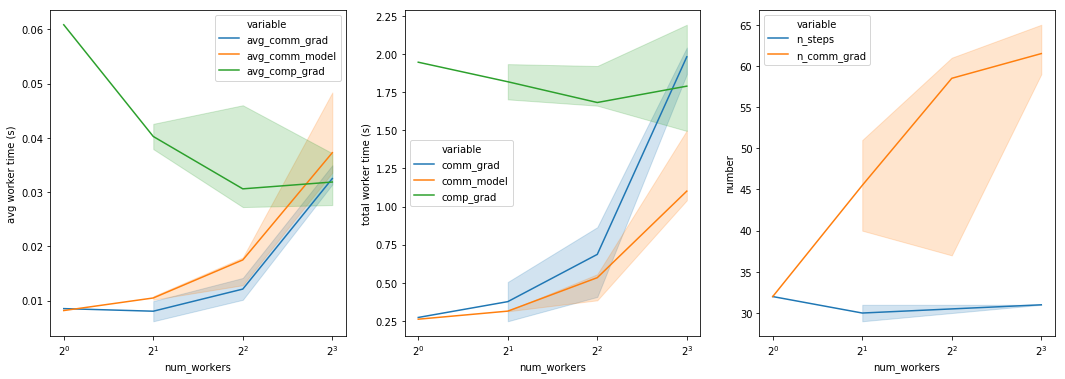

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

variables = {'avg worker time (s)': ['avg_comm_grad', 'avg_comm_model', 'avg_comp_grad'],
             'total worker time (s)': ['comm_grad', 'comm_model', 'comp_grad'],
             'number': ['n_steps', 'n_comm_grad']}

w = 6
plt, axs = plt.subplots(ncols=3, figsize=(3*w, w))
for (label, values), ax in zip(variables.items(), axs):
    show = df.melt(id_vars=['num_workers'], value_vars=values, value_name=label)
    sns.lineplot(data=show, x='num_workers', hue='variable', y=label,
                 estimator=np.median, ax=ax)
    ax.set_xscale('log', basex=2)
plt.savefig('times.png', dpi=300)

### Serialization time

Wait time is a lot of serialization time, + 1-2ms each way

In [16]:
model = Net()
num_workers = 4
device = torch.device("cuda" if use_cuda else "cpu")

ps = client.submit(PS, model, args, device,
                   max_iter=30, num_workers=num_workers,
                   actor=True, ).result()

In [17]:
%timeit model = ps.model

100 loops, best of 3: 6.32 ms per loop


In [18]:
from distributed.protocol import serialize, deserialize
%timeit _ = deserialize(*serialize(model))

100 loops, best of 3: 4.22 ms per loop


In [21]:
%load_ext snakeviz

In [23]:
%%snakeviz  
for i in range(100):
    deserialize(*serialize(model))

 
*** Profile stats marshalled to file '/var/folders/kk/wvsqd9_j5j12y8bszfc6gr9h0000gp/T/tmpyi76hecc'. 
